In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce 

# для нормализации, стандартизации
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# Знакомство с данными

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
# посмотрим, есть ли дубликаты в тренировочном датасете
df_train.duplicated().sum()

307

In [8]:
# удалим дубликаты
df_train = df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386496 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386496 non-null  object 
 1   additional_number_of_scoring                386496 non-null  int64  
 2   review_date                                 386496 non-null  object 
 3   average_score                               386496 non-null  float64
 4   hotel_name                                  386496 non-null  object 
 5   reviewer_nationality                        386496 non-null  object 
 6   negative_review                             386496 non-null  object 
 7   review_total_negative_word_counts           386496 non-null  int64  
 8   total_number_of_reviews                     386496 non-null  int64  
 9   positive_review                             386496 non-null  object 
 

In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [10]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [13]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

**Признаки**

hotel_address - адрес отеля

review_date - дата, когда рецензент разместил соответствующий отзыв

average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год

hotel_name - название отеля

reviewer_nationality - национальность рецензента

negative_review - отрицательный отзыв, который рецензент дал отелю

review_total_negative_word_counts - общее количество слов в отрицательном отзыв

positive_review - положительный отзыв, который рецензент дал отелю

review_total_positive_word_counts - общее количество слов в положительном отзыве

reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта

total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом

total_number_of_reviews - общее количество действительных отзывов об отеле

tags - теги, которые рецензент дал отелю

days_since_review - продолжительность между датой проверки и датой очистки

additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки

lat - широта отеля

lng - долгота отеля

In [15]:
# уникальные значения
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

In [16]:
# описательные статистики
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,lat,lng,sample,reviewer_score
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,512163.000000,512163.000000,515431.00000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,49.442788,2.824057,0.74985,6.296715
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.467323,4.580730,0.43310,3.902967
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,41.328376,-0.369758,0.00000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,48.214277,-0.143372,0.00000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,51.499981,-0.000250,1.00000,7.900000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,51.516288,4.834443,1.00000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,52.400181,16.429233,1.00000,10.000000


In [17]:
# описательные статистики для типа 'object'
data.describe(include=['object'])

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
count,515431,515431,515431,515431,515431,515431,515431,515431
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2584,4789,245165,127816,35924,5101,2584


Как видим из описательных статистик оценка, которую рецензент поставил отелю на основе своего опыта варьируется от 1 до 10, среднее значение - 6.3.

Средний балл отеля, рассчитанный на основе последнего комментария за последний год находится в интервале от 5.2 до 9.8, среднее значение - 8.4.

Большинство рецензентов из Великобритании (почти половина).

Среднее количество слов в негативных и позитивных отзывах примерно одинаковое - 18.5 и 17.8 соответственно. Большинство отзывов состоят из слов "No Negative", "No Positive".


# Очистка от пропущенных значений

In [18]:
# выведем названия столбцов, где число пропусков больше 0 
data.isnull().mean()[data.isnull().mean() > 0]

lat    0.00634
lng    0.00634
dtype: float64

Одинаковое количество уникальных значений (1473) и пропущенных говорит о том, что пропуски парные.

In [19]:
# выведем адреса отелей, в которых отсутствуют координаты
unknown_locs = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]
unknown_locs

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,0,0
23 Rue Damr mont 18th arr 75018 Paris France,0,0
4 rue de la P pini re 8th arr 75008 Paris France,0,0
Bail n 4 6 Eixample 08010 Barcelona Spain,0,0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,0,0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,0,0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,0,0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,0,0
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,0,0


In [20]:
# заполним недостающие координаты
locs = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

for i in range (17):
    unknown_locs.iloc[i] = locs[i]
unknown_locs

,lat,lng
hotel_address,,
20 Rue De La Ga t 14th arr 75014 Paris France,48.839996,2.307082
23 Rue Damr mont 18th arr 75018 Paris France,48.888913,2.330964
4 rue de la P pini re 8th arr 75008 Paris France,48.875321,2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain,41.391552,2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria,48.220855,16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria,48.233592,16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria,48.209405,16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria,48.209553,16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria,48.188818,16.381591


In [21]:
# заполним в датасете пропущенные координаты
data = data.set_index('hotel_address')
data.update(unknown_locs)
data = data.reset_index()

In [22]:
# проверим что пропусков не осталось
print(data[data['lat'].isna()].shape[0])
print(data[data['lng'].isna()].shape[0])

0
0


# Создание новых признаков

In [23]:
# напишем функцию, которая преобразовывает строку с тегами в список
def get_tags_list(string):
    string = string.replace(', ', '')
    string = string[2:-2]
    tags_list = string.split("''")
    return tags_list

# применим функцию
data['tags'] = data['tags'].apply(get_tags_list)
data['tags'].head()

0    [ Leisure trip ,  Couple ,  Double Room ,  Sta...
1    [ Leisure trip ,  Group ,  Triple Room ,  Stay...
2    [ Business trip ,  Solo traveler ,  Twin Room ...
3    [ Leisure trip ,  Couple ,  Ambassador Junior ...
4    [ Business trip ,  Solo traveler ,  Classic Do...
Name: tags, dtype: object

In [24]:
# создадим словарь с тегами
dict_tags = {}
for row in data['tags']:
    for tag in row:
        if tag in dict_tags:
            dict_tags[tag] += 1
        else:
            dict_tags[tag] = 1
            
# создадим список тегов и выведем самые популярные            
tags_list = pd.Series(dict_tags).sort_values(ascending=False) 
print('Количество тегов:', tags_list.shape[0]) 
tags_list.head(20) 

Количество тегов: 2428


 Leisure trip                       417538
 Submitted from a mobile device     307470
 Couple                             252128
 Stayed 1 night                     193568
 Stayed 2 nights                    133850
 Solo traveler                      108476
 Stayed 3 nights                     95761
 Business trip                       82884
 Group                               65361
 Family with young children          60989
 Stayed 4 nights                     47777
 Double Room                         35207
 Standard Double Room                32247
 Superior Double Room                31361
 Family with older children          26334
 Deluxe Double Room                  24812
 Double or Twin Room                 22393
 Stayed 5 nights                     20826
 Standard Double or Twin Room        17479
 Classic Double Room                 16877
dtype: int64

Среди тегов встречается множество таких, которые указывают на сколько ночей чаще всего останавливаются путешественники в отелях

In [25]:
# cоздадим признак, который будет указывать на длительность пребывания и преобразуем его в число:

def get_count_night(row):
    for elem in row:
        if 'Stayed' in elem:
            return elem.split()[1]
    return 0

data['stayed_night'] = data['tags'].apply(get_count_night).astype(int)

# Выведем количество уникальных значений
print(data['stayed_night'].nunique()) 

32


In [26]:
# преобразуем признак даты в формат datetime для удобной работы
data['review_date'] = pd.to_datetime(data['review_date'])

# создадим новые признаки: год, месяц и квартал размещения отзыва
data['year'] = data['review_date'].dt.year 
data['month'] = data['review_date'].dt.month 
data['quarter'] = data['review_date'].dt.quarter 

# узнаем когда был оставлен самый первый и самый свежий отзывы
data['review_date'].min(), data['review_date'].max()

(Timestamp('2015-08-04 00:00:00'), Timestamp('2017-08-03 00:00:00'))

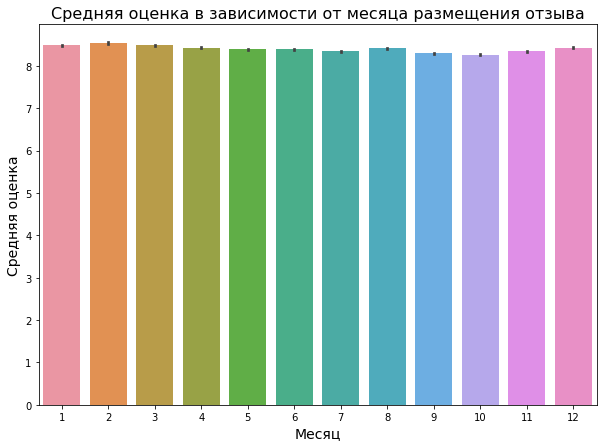

In [27]:
# посмотрим зависимость средней оценки отеля от месяца размещения отзыва
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=data[data['sample'] == 1], # тренировочный датасет, т.к. в тестовом оценка = 0
    x='month',
    y='reviewer_score',
    estimator=np.mean
)
barplot.set_title('Средняя оценка в зависимости от месяца размещения отзыва', fontsize=16)
barplot.set_xlabel('Месяц', fontsize=14)
barplot.set_ylabel('Средняя оценка', fontsize=14);

Как видно на графике, средняя оценка в зависимости от месяца отличается незначительно

In [28]:
# Извлечем количество дней из столбца 'days_since_review' и преобразуем его в числовой вид:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))
data['days_since_review']

0          13
1         234
2         616
3         656
4         444
         ... 
515426    106
515427    171
515428    543
515429     74
515430    363
Name: days_since_review, Length: 515431, dtype: int64

In [29]:
# посмотрим на признак 'hotel_address'
for row in data['hotel_address'].head(10):
    print(row)

Via Senigallia 6 20161 Milan Italy
Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands
Mallorca 251 Eixample 08008 Barcelona Spain
Piazza Della Repubblica 17 Central Station 20124 Milan Italy
Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands
Coram Street Camden London WC1N 1HT United Kingdom
Empire Way Wembley Brent London HA9 8DS United Kingdom
1 Shortlands Hammersmith and Fulham London W6 8DR United Kingdom
35 Rue Caumartin 9th arr 75009 Paris France
49 Gloucester Place Marble Arch Westminster Borough London W1U 8JE United Kingdom


In [30]:
# создадим новый признак "country" из 'hotel_address'
data['country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])
data['country'].value_counts()

United Kingdom    262300
Spain              60149
France             59626
Netherlands        57212
Austria            38938
Italy              37206
Name: country, dtype: int64

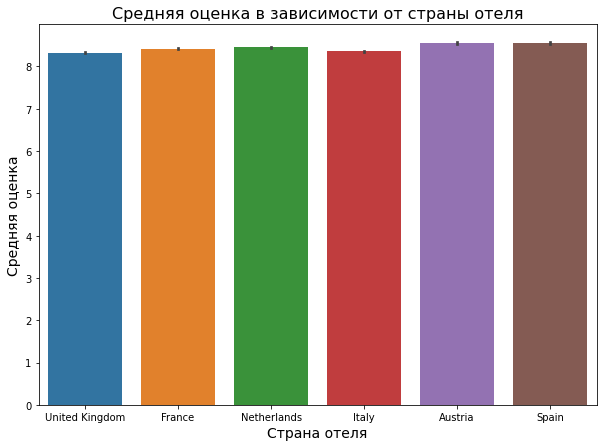

In [31]:
# посмотрим на графике зависимость средней оценки отеля от страны. в которой он расположен
fig = plt.figure(figsize=(10, 7))
barplot = sns.barplot(
    data=data[data['sample'] == 1], # тренировочный датасет, т.к. в тестовом оценка = 0
    x='country',
    y='reviewer_score',
    estimator=np.mean
)
barplot.set_title('Средняя оценка в зависимости от страны отеля', fontsize=16)
barplot.set_xlabel('Страна отеля', fontsize=14)
barplot.set_ylabel('Средняя оценка', fontsize=14);

Как видно на графике страна также значительно не влияет на среднюю оценку отеля

Преобразуем категориальные данные в признаки, пригодные для обучения:

In [32]:
# закодируем признак 'country' (однократное кодирование)
encoder = ce.OneHotEncoder(cols=['country']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['country'],axis=1,inplace=True)

In [33]:
# закодируем признак 'reviewer_nationality' (двоичное кодирование)
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['reviewer_nationality'],axis=1,inplace=True)

In [34]:
# закодируем признак 'hotel_name' (двоичное кодирование)
bin_encoder = ce.BinaryEncoder(cols=['hotel_name']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['hotel_name'])
data = pd.concat([data, type_bin], axis=1)
data.drop(['hotel_name'],axis=1,inplace=True)

In [35]:
# посмотрим, что получилось
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   additional_number_of_scoring                515431 non-null  int64         
 2   review_date                                 515431 non-null  datetime64[ns]
 3   average_score                               515431 non-null  float64       
 4   negative_review                             515431 non-null  object        
 5   review_total_negative_word_counts           515431 non-null  int64         
 6   total_number_of_reviews                     515431 non-null  int64         
 7   positive_review                             515431 non-null  object        
 8   review_total_positive_word_counts           515431 non-null  int64        

# Преобразование признаков. 

Проведем преобразования над количественными (непрерывными) признаками, у которых высокие максимальные значения

In [36]:
# описательные статистики до преобразования
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,...,hotel_name_1,hotel_name_2,hotel_name_3,hotel_name_4,hotel_name_5,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,354.405492,49.432744,2.893755,0.74985,...,0.286153,0.390956,0.460221,0.471541,0.486189,0.482988,0.497386,0.516936,0.509725,0.485710
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,208.915335,3.461235,4.668765,0.43310,...,0.451962,0.487965,0.498416,0.499190,0.499810,0.499711,0.499994,0.499714,0.499906,0.499796
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.214066,-0.143372,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.019886,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,527.000000,51.516288,4.841163,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


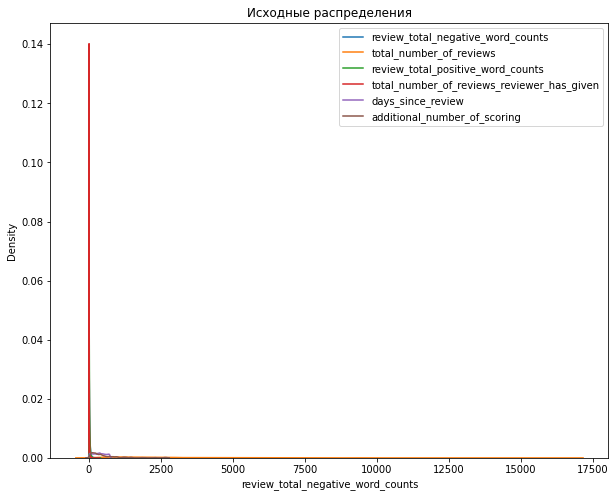

In [37]:
# проверим визуально данные признаки на нормальное распределение
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(data['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(data['days_since_review'], ax=ax1, label ='days_since_review')
sns.kdeplot(data['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')

plt.legend()

Как видно, нормального распределения среди данных признаков не наблюдается, поэтому проведём нормализацию распределений признаков, используя класс RobustScaler

In [38]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# создадим список имен столбцов
col_names = ['review_total_negative_word_counts', 'total_number_of_reviews', 'total_number_of_reviews_reviewer_has_given', 
             'days_since_review', 'review_total_positive_word_counts', 'additional_number_of_scoring']

df_r = r_scaler.fit_transform(data[col_names]) # произведем нормализацию столбцов
df_r = pd.DataFrame(df_r, columns=col_names) # преобразуем в датафрейм
data = data.drop(col_names, axis=1) # удалим исходные столбцы
data = pd.concat([data, df_r], axis=1) # добавим новые

data.info() # посмотрим какие получились столбцы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   negative_review                             515431 non-null  object        
 4   positive_review                             515431 non-null  object        
 5   tags                                        515431 non-null  object        
 6   lat                                         515431 non-null  float64       
 7   lng                                         515431 non-null  float64       
 8   sample                                      515431 non-null  int64        

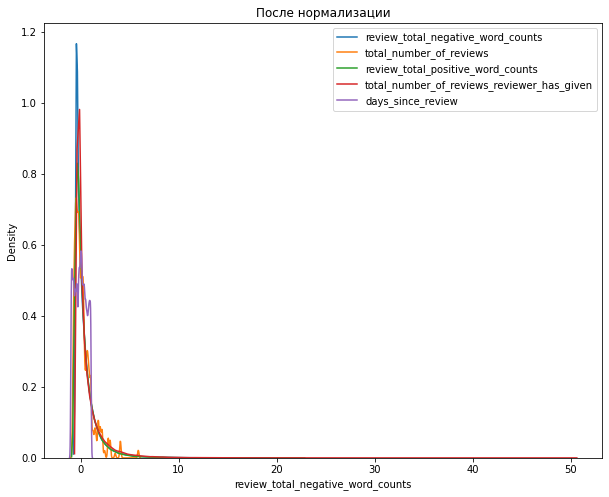

In [39]:
# посмотрим на распредление признаков после нормализации
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(data['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(data['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(data['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(data['total_number_of_reviews_reviewer_has_given'], ax=ax1, label ='total_number_of_reviews_reviewer_has_given')
sns.kdeplot(data['days_since_review'], ax=ax1, label ='days_since_review')

plt.legend()

In [40]:
# описательные статистики после нормализации
data.describe()

,average_score,lat,lng,sample,reviewer_score,stayed_night,year,month,quarter,country_1,...,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,review_total_negative_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,review_total_positive_word_counts,additional_number_of_scoring
count,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,515431.000000,515431.000000,515431.00000,515431.000000,515431.000000,...,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000
mean,8.397630,49.432744,2.893755,0.74985,6.296715,2.361129,2016.120897,6.48623,2.503282,0.072184,...,0.497386,0.516936,0.509725,0.485710,0.454274,0.246869,0.595031,0.003993,0.398667,0.318279
std,0.548033,3.461235,4.668765,0.43310,3.902967,1.647346,0.687524,3.35188,1.088495,0.258793,...,0.499994,0.499714,0.499906,0.499796,1.413856,0.937631,1.576963,0.593509,1.282541,1.019591
min,5.200000,41.328376,-0.369758,0.00000,0.000000,0.000000,2015.000000,1.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.428571,-0.845874,-0.285714,-1.002841,-0.647059,-0.694501
25%,8.100000,48.214066,-0.143372,0.00000,0.000000,1.000000,2016.000000,4.00000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.333333,-0.393608,-0.285714,-0.505682,-0.352941,-0.352342
50%,8.400000,51.499981,0.019886,1.00000,7.900000,2.000000,2016.000000,7.00000,3.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.800000,51.516288,4.841163,1.00000,9.600000,3.000000,2017.000000,9.00000,3.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.666667,0.606392,0.714286,0.494318,0.647059,0.647658
max,9.800000,52.400181,16.429233,1.00000,10.000000,31.000000,2017.000000,12.00000,4.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,19.000000,5.880259,50.285714,1.071023,22.588235,4.765784


# Отбор признаков

Признаки могут дублировать информацию. Будем использовать анализ мультиколлинеарности, чтобы выбрать уникальные признаки для модели.

<AxesSubplot:>

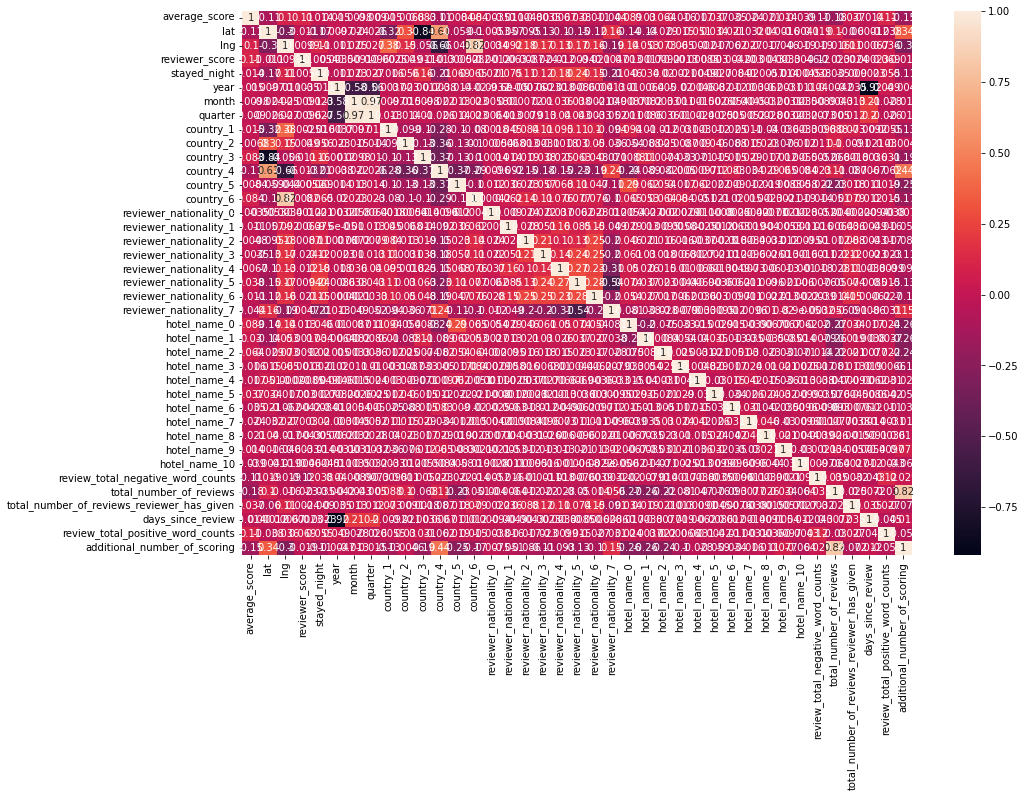

In [41]:
# корреляция признаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [42]:
# выведем пары признаков с очень сильной корреляцией (где коэффициент корреляции +/-0.7 и выше)
corr = data.drop(['sample'], axis=1).corr().abs().unstack().reset_index()
corr = corr.rename(columns = {'level_0' : 'sign_1', 'level_1' : 'sign_2', 0 : 'correlation' }).\
     sort_values(by = 'correlation', ascending = False)
corr[(corr['sign_1'] != corr['sign_2']) & (corr['correlation'] > 0.7)]

,sign_1,sign_2,correlation
279,quarter,month,0.969877
241,month,quarter,0.969877
231,year,days_since_review,0.917248
1409,days_since_review,year,0.917248
391,country_3,lat,0.844690
49,lat,country_3,0.844690
509,country_6,lng,0.824922
91,lng,country_6,0.824922
1516,additional_number_of_scoring,total_number_of_reviews,0.824904
1364,total_number_of_reviews,additional_number_of_scoring,0.824904


Также перед обучением (после разделения выборки на X и y) мы можем оценить значимость каждого признака для целевой переменной — рейтинг отеля. 

Для оценки значимости категориальных признаков будем использовать тест хи-квадрат, для непрерывных признаков — тест ANOVA.

Для начала разделим признаки по типу, перечислим их:

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 45 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   negative_review                             515431 non-null  object        
 4   positive_review                             515431 non-null  object        
 5   tags                                        515431 non-null  object        
 6   lat                                         515431 non-null  float64       
 7   lng                                         515431 non-null  float64       
 8   sample                                      515431 non-null  int64        

In [44]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'additional_number_of_scoring', 'total_number_of_reviews_reviewer_has_given', 'days_since_review']

# категориальные признаки 
cat_cols = [col for col in data.columns if col not in num_cols]

In [45]:
# удалим из cat_cols лишние признаки
cat_cols.remove('sample')
cat_cols.remove('reviewer_score')
cat_cols.remove('hotel_address')
cat_cols.remove('review_date')
cat_cols.remove('negative_review')
cat_cols.remove('positive_review')
cat_cols.remove('tags')
cat_cols.remove('lng')   # отрицательные числа

Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат, реализованный в библиотеке sklearn.feature_selection.chi2. Метод возвращает массив значений хи-квадрат и p-value для каждого признака. Используем только значения хи-квадрат и выведем их на графике:

<AxesSubplot:>

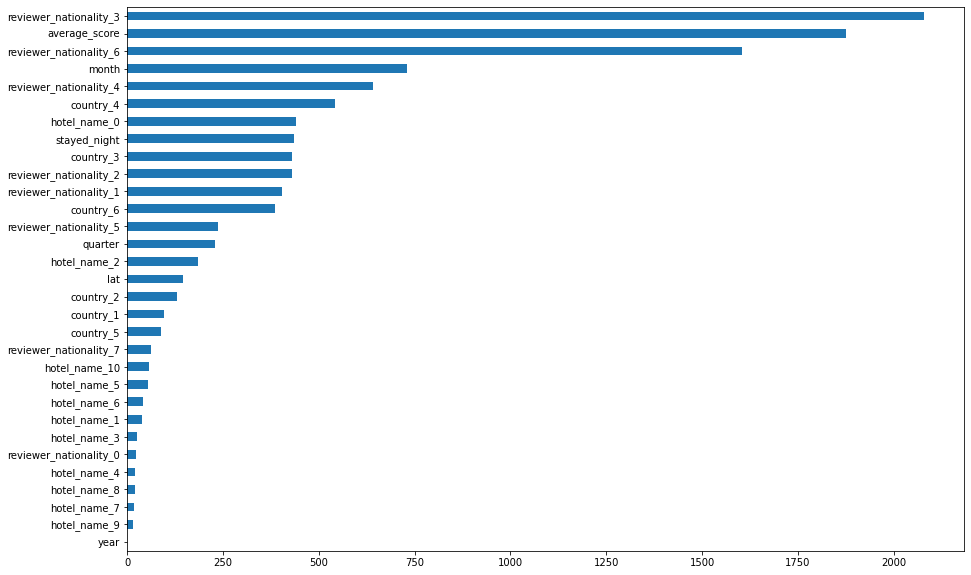

In [46]:
# разделим выборку на X и y
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values
X = data.query('sample == 1').drop(['sample', 'reviewer_score'], axis=1)

y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

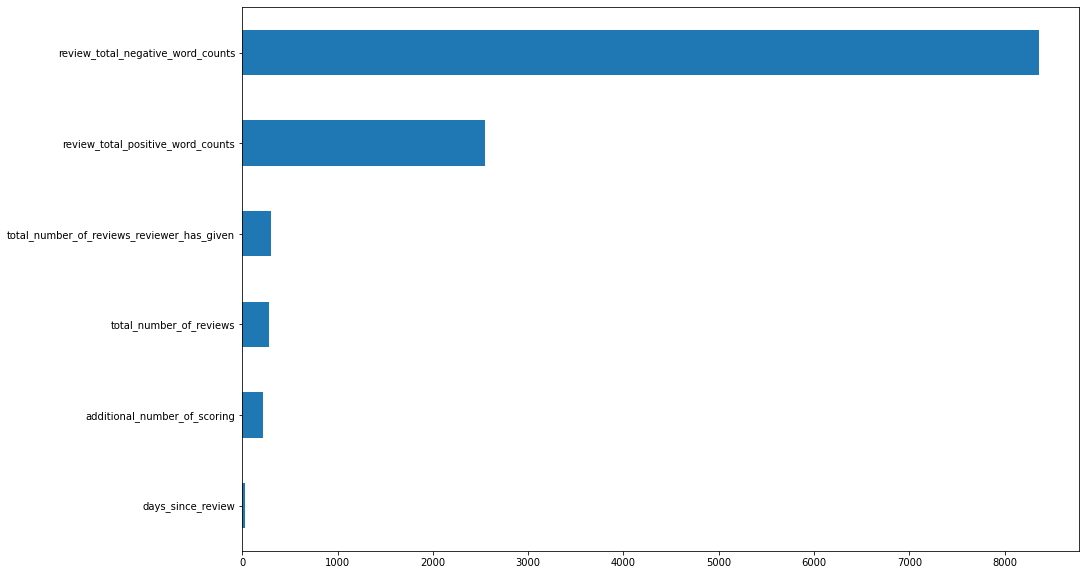

In [47]:
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn 
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [48]:
# удалим сильно скоррелированные и менее значимые признаки для целевой переменной
drop_columns = ['year', 'lng', 'lat', 'quarter', 'additional_number_of_scoring']
data.drop(drop_columns, axis = 1, inplace=True)

,sign_1,sign_2,correlation


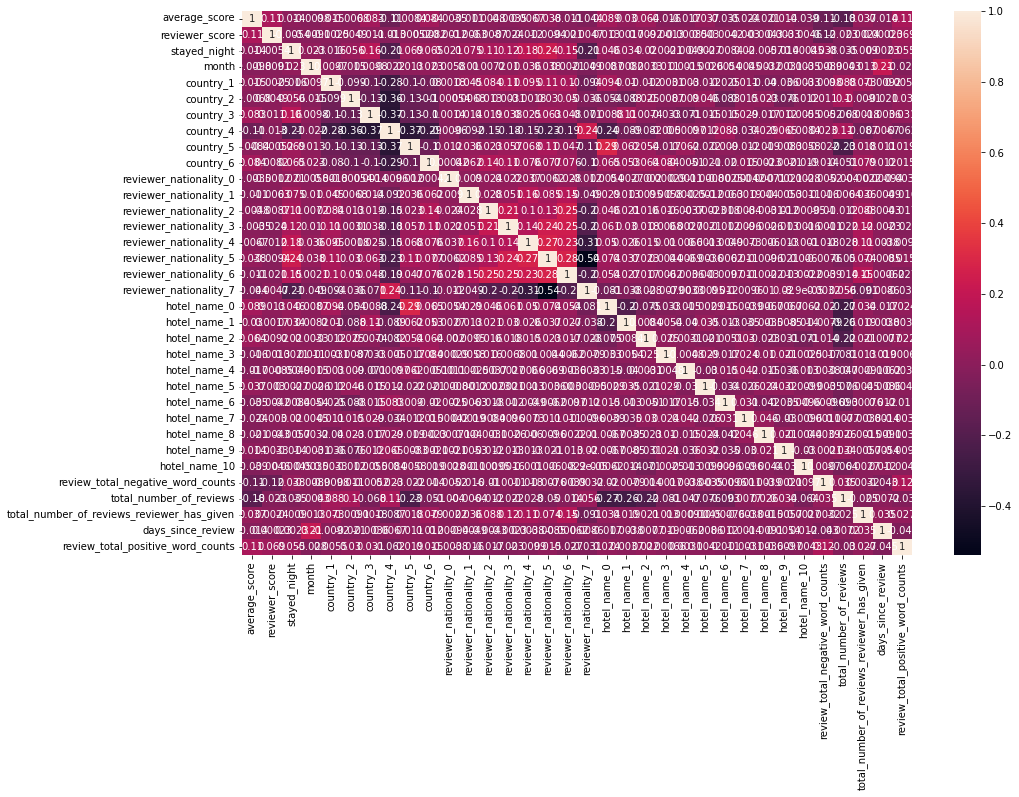

In [49]:
# проверяем, что сильно скоррелированных признаков не осталось
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

corr = data.drop(['sample'], axis=1).corr().abs().unstack().reset_index()
corr = corr.rename(columns = {'level_0' : 'sign_1', 'level_1' : 'sign_2', 0 : 'correlation' }).\
     sort_values(by = 'correlation', ascending = False)
corr[(corr['sign_1'] != corr['sign_2']) & (corr['correlation'] > 0.7)]

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515431 non-null  object        
 1   review_date                                 515431 non-null  datetime64[ns]
 2   average_score                               515431 non-null  float64       
 3   negative_review                             515431 non-null  object        
 4   positive_review                             515431 non-null  object        
 5   tags                                        515431 non-null  object        
 6   sample                                      515431 non-null  int64         
 7   reviewer_score                              515431 non-null  float64       
 8   stayed_night                                515431 non-null  int64        

# Обучение модели

In [51]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" и "datetime" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 35 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515431 non-null  float64
 1   sample                                      515431 non-null  int64  
 2   reviewer_score                              515431 non-null  float64
 3   stayed_night                                515431 non-null  int64  
 4   month                                       515431 non-null  int64  
 5   country_1                                   515431 non-null  int64  
 6   country_2                                   515431 non-null  int64  
 7   country_3                                   515431 non-null  int64  
 8   country_4                                   515431 non-null  int64  
 9   country_5                                   515431 non-null  int64  
 

In [53]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 34), (386496, 34), (386496, 33), (309196, 33), (77300, 33))

In [56]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [57]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [58]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


In [59]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
# Функция для вычисления MAPE
def mape_func(y_test,y_pred):
    mape = np.mean(np.abs((y_test - y_pred)/y_test))*100
    return mape

print('MAPE:', mape_func(y_test, y_pred)) 

MAPE: 13.596604024330142


In [60]:
# Метрика Mean Absolute Error (MAE) показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.9407258293291441


<AxesSubplot:>

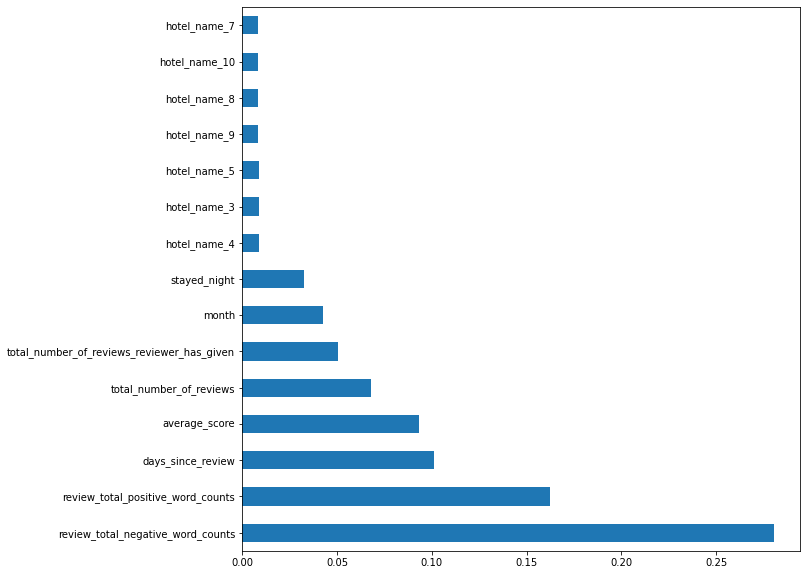

In [61]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [62]:
test_data.sample(10)

,average_score,reviewer_score,stayed_night,month,country_1,country_2,country_3,country_4,country_5,country_6,...,hotel_name_6,hotel_name_7,hotel_name_8,hotel_name_9,hotel_name_10,review_total_negative_word_counts,total_number_of_reviews,total_number_of_reviews_reviewer_has_given,days_since_review,review_total_positive_word_counts
96025,8.5,0.0,1,8,0,0,0,1,0,0,...,0,1,0,0,1,0.000000,-0.218851,0.142857,-0.002841,1.529412
107034,8.6,0.0,4,7,0,0,1,0,0,0,...,1,0,1,1,1,-0.428571,0.908172,2.000000,0.125000,-0.411765
92064,8.1,0.0,2,12,0,0,0,0,0,1,...,0,1,0,1,1,-0.190476,0.709142,0.000000,-0.383523,-0.647059
37991,9.3,0.0,2,1,0,0,0,1,0,0,...,0,1,0,0,0,-0.428571,0.074838,-0.285714,-0.423295,0.117647
89719,9.0,0.0,2,1,1,0,0,0,0,0,...,0,1,0,0,0,3.000000,0.257282,1.000000,0.625000,0.470588
38873,7.3,0.0,1,1,0,0,0,1,0,0,...,0,0,1,0,1,2.000000,0.596683,0.428571,-0.426136,1.000000
34677,7.5,0.0,4,10,0,0,0,1,0,0,...,1,1,0,1,0,0.380952,1.232201,0.142857,0.840909,-0.647059
46163,7.5,0.0,4,5,0,0,0,1,0,0,...,1,1,1,1,1,0.238095,1.959142,1.285714,0.281250,-0.411765
89506,8.0,0.0,3,3,0,1,0,0,0,0,...,0,0,1,0,0,0.142857,-0.517799,2.428571,0.389205,-0.058824
30388,8.5,0.0,2,1,0,0,0,1,0,0,...,1,0,0,1,1,1.047619,0.459142,0.142857,-0.417614,-0.294118


In [63]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [64]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [65]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


In [66]:
predict_submission

array([8.629, 6.909, 8.226, ..., 8.131, 9.549, 7.   ])

In [67]:
list(sample_submission)

['reviewer_score', 'id']

In [68]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.629,488440
1,6.909,274649
2,8.226,374688
3,9.343,404352
4,9.802,451596
5,8.652,302161
6,8.362,317079
7,8.151,13963
8,8.684,159785
9,8.039,195089
